## In this notebook... 

### We try to finetune model on herbarium subset then use it to train the prototype networks 

We pretrain a vanilla classifier on a subset of the Herbarium Dataset to use as base for the Prototypical Network in later notebooks. To this end, we use a subset of the full training set. The subset is such that there are enough samples for each class and that there are enough classes to learn (GPU allowing). The classifier is trained using fastai. Specifically, we train the classifier in 2 phases: train head only with frozen arch then train entire model unfrozen. GPU allowing, we fine-tune the classifier once more on images with higher resolution.

The vanilla classifier is trained with a Resnet-based arch with a fastai head. This of course can be changed, the arch in particular. We tried a SeResNet but this didn't seem to improve too much if at all. I include the sample code to train on more exotic archs from timm anyway, though my GPU can't handle even a moderate batchsize with these arches so the "sample" performance might be deceptively low.

Finally, we save the model weights to be loaded in later notebooks.

## load libraries 

In [1]:

import random
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

In [18]:
plt.rcParams['figure.figsize'] = [20, 20]
sns.set(font_scale=2.)

pd.set_option('display.width', -1)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)

def set_fig_size(x,y):
    plt.rcParams['figure.figsize'] = [x, y]
    sns.set(font_scale=2.)

C:\Users\htngu\Anaconda3\envs\kaggle_pandas\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [2]:
# set env to be running on CPU, use this when debugging
#os.environ['CUDA_VISIBLE_DEVICES']=''

In [3]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'

In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [6]:
from datetime import datetime

In [7]:
from fastai import *
from fastai.vision import *

In [8]:
import numpy as np                                    # Array, Linear Algebra
from torch.utils.data.dataset import random_split     # spliting inTrain Val
import pandas as pd                                   # handling CSV
import os                                             # For File handling
import random                                         # Choosing from images dataset
import time                                           # timing Epochs  
from tqdm.notebook import tqdm                        # Testing
from os.path import join                              # File Handling
from torchvision import transforms                    # Data Aug
import torch                                          # Framework
from PIL import Image                                 # Loading Image
from torch.utils.data import Dataset, DataLoader      # Dataset
import torch.nn.functional as F                       # Function
import json                                           # Loading Metadat
from PIL import  ImageOps                             # Data Aug 
from PIL.Image import open as openIm                  # Image Handling
import matplotlib.pyplot  as plt                      # Ploting Image
import cv2
from sklearn.metrics import f1_score
import seaborn as sns

#### Add the path to few_shot repo to get the relevant functions

In [9]:
import sys
#sys.path.append('/bigdata/user/hieunt124/submodules/few_shot/')
sys.path.append('./few_shot/')

In [10]:
"""
Reproduce Omniglot results of Snell et al Prototypical networks.
"""
from torch.optim import Adam
from torch.utils.data import DataLoader
import argparse

from few_shot.datasets import OmniglotDataset, MiniImageNet
from few_shot.models import get_few_shot_encoder
from few_shot.core import NShotTaskSampler, EvaluateFewShot, prepare_nshot_task
from few_shot.proto import proto_net_episode
from few_shot.train import fit
from few_shot.callbacks import *
from few_shot.utils import setup_dirs
from config import PATH


In [11]:
'''
import vision stuff
'''
import torchvision
import torch.nn as nn

In [12]:
#torch.set_num_threads(3)

### Locate the directories and load the metadata

In [13]:
#base_dir = '/bigdata/user/hieunt124/kaggle/herbarium/'
base_dir = 'D:/Data/Kaggle_HerbariumChallenge2020'
train_dir = base_dir + '/nybg2020/train/'
test_dir = base_dir + '/nybg2020/test/'
metadata_file = 'metadata.json'

In [14]:

with open(train_dir + metadata_file, encoding = "ISO-8859-1") as json_file:
    train_metadata = json.load(json_file)

train_img = pd.DataFrame(train_metadata['images'])
train_label = pd.DataFrame(train_metadata['annotations'])
train_df = (pd.merge(train_label, train_img
                    #, left_on='image_id'
                    , on='id'
                    , how='left')
            .drop(['image_id', 'license', 'region_id'], axis=1)
            .sort_values(by=['category_id'])
           )
train_df.head()

,category_id,id,file_name,height,width
76407,0,626762,images/000/00/626762.jpg,1000,681
601590,0,72077,images/000/00/72077.jpg,1000,681
76408,0,818271,images/000/00/818271.jpg,1000,681
556748,0,495523,images/000/00/495523.jpg,1000,681
335261,0,437000,images/000/00/437000.jpg,1000,681


There are roughly a million images in the training set.

In [15]:
train_df.shape

(1030747, 5)

In [16]:
train_df.rename(columns={'category_id': 'class_id'
                        , 'file_name': 'filepath'
                        }, inplace=True)

### Select the classes with relatively high sample sizes

Most classes have very few samples, certainly not enough to build a vanilla classifier, certainly not for so many classes.

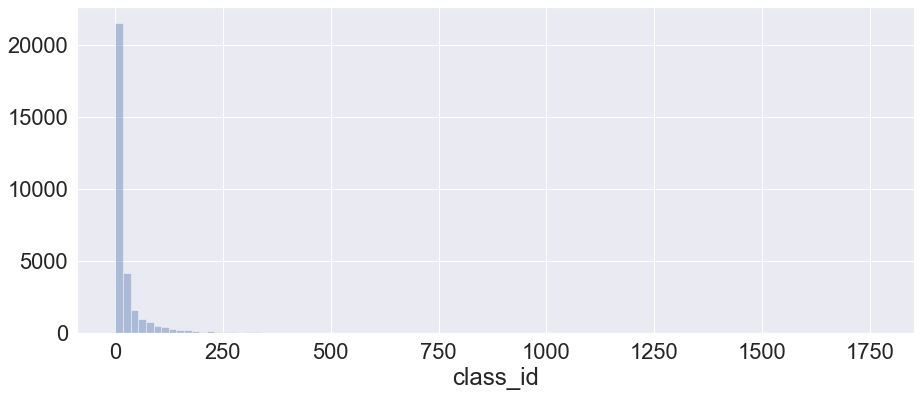

In [29]:
set_fig_size(15,6)
sns.distplot(train_df.class_id.value_counts(), kde=False, bins=100)

For example, the least populous 20k classes have no more than 15 samples.

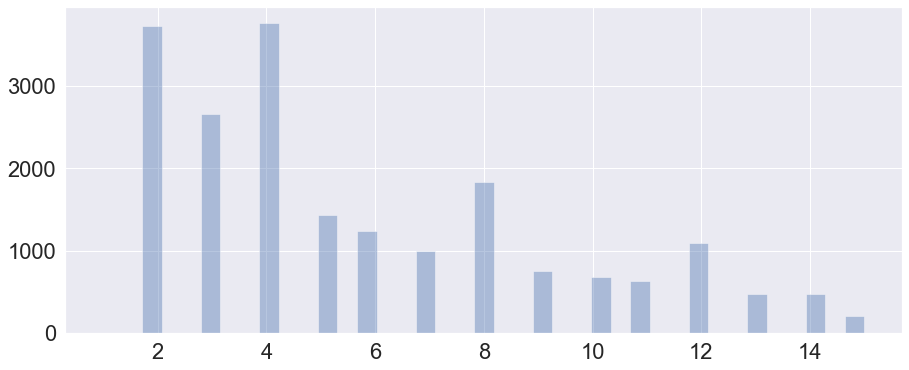

In [34]:
sns.distplot(train_df.class_id.value_counts().values[-20000:]
             , kde=False
            )

Instead, we select the top populated classes to train a vanilla classifier on.

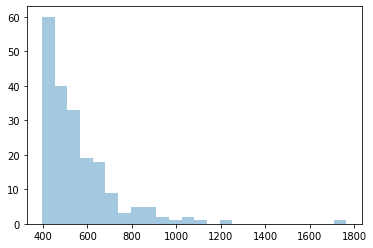

In [17]:
sns.distplot(train_df.class_id.value_counts().values[:200]
             , kde=False
            )

In the version used for kaggle, I used N_CLASSES=200 or so (might've been 100 not sure). Here I used 10 classes so it's faster.

In [18]:
N_CLASSES = 10

In [19]:
high_samples_classes = train_df.class_id.value_counts()[:N_CLASSES].index.tolist()

In [20]:
#temp_filter = (train_df.class_id.isin(list(train_df.class_id.unique()[500:1000])))
temp_filter = (train_df.class_id.isin(high_samples_classes))
source = ImageList.from_df(train_df[temp_filter]
                           , train_dir
                           , cols='filepath'
                           #, 
                          )

In [21]:
train_df[temp_filter].shape

(10766, 5)

### Create the data object for fastai-based training

In [22]:
source = (source
 .split_by_rand_pct(0.2)
 .label_from_df(cols='class_id')
)

We also use transforms to augment data. 

In [23]:
transforms = get_transforms(flip_vert=True
                            #, max_lighting=.1
                            #, max_zoom=1.05
                            #, max_warp=0.
                           )

The batchsize and image size depend on GPU capabilities and how big the base model is. Resnet for example is small so there's more leeway with a low-grade GPU. More sophisticated archs will be more demanding. Check with nvidia-smi.

For ResNet50, we went with bs=128 and size=128 for the frozen-unfrozen phases. Then with bs=32, size=256 when training with higher resolution. This should be fine for a 6GB GPU.

In [24]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [25]:
data = (source
        .transform(tfms=transforms, size=IMAGE_SIZE)
        .databunch(bs=BATCH_SIZE, num_workers=0)
        .normalize(imagenet_stats))

In [26]:
# number of batches
data.__len__()

269

In [27]:
# number of classes
data.c

10

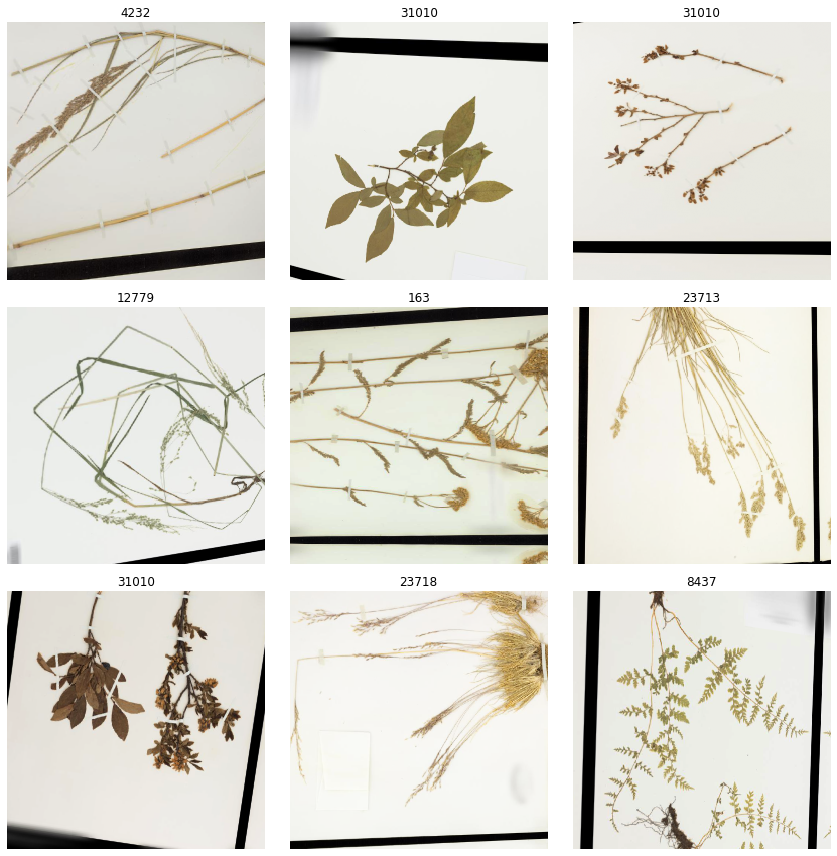

In [28]:
data.show_batch(3)

###  define model architecture

Since the model is to be loaded and trained later in a different settings to fastai (as opposed to the usual learner object), it's defined here in a slightly more manual manner so I can basically copy the architecture later to the other notebooks.

In [29]:
from efficientnet_pytorch import EfficientNet
from torchsummary import summary
from torch.nn.modules import Dropout

In [30]:
from fastai.layers import Flatten, AdaptiveConcatPool2d
def my_head(input_size, hidden_units, output_size):
        return nn.Sequential(AdaptiveConcatPool2d()
                                        , Flatten()
                                        , nn.BatchNorm1d(num_features=2 * input_size)
                                        , nn.Dropout(p=.25)
                                        , nn.Linear(in_features=2 * input_size, out_features=hidden_units, bias=True)
                                        , nn.ReLU(inplace=True)
                                        , nn.BatchNorm1d(num_features=hidden_units)
                                        , nn.Dropout(p=.5)
                                        , nn.Linear(in_features=hidden_units, out_features=output_size, bias=True)
                                        
                                       )

In [31]:
import timm

In [32]:
#from pretrainedmodels import se_resnext50_32x4d, se_resnet101

In [33]:
#arch = se_resnext50_32x4d(pretrained='imagenet')
#arch = se_resnet101(pretrained='imagenet')
arch = torchvision.models.resnet50(pretrained=False)

In [34]:
arch = list(arch.children())
arch.pop(-1)
arch.pop(-1)
temp_arch = nn.Sequential(nn.Sequential(*arch))
temp_children = list(temp_arch.children())
temp_children.append(my_head(2048, 512, N_CLASSES))
model = nn.Sequential(*temp_children)

In [35]:
for param in (list(model.parameters()))[:-6]:
    param.requires_grad=False

In [36]:
model.to('cuda')

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [37]:
model_summary = summary(model, input_size=(3,IMAGE_SIZE,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [38]:
macro_fscore = FBeta(average='macro', beta=1)

In [39]:
#learn = cnn_learner(data, model, metrics=[macro_fscore])
learn = Learner(data, model, metrics=[macro_fscore])

In [43]:
torch.cuda.is_available()

True

### train model head with frozen arch 

We adopt the routine from the fastai courses: look for a good (range of) lr, train using cyclic learning rate schedule.

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


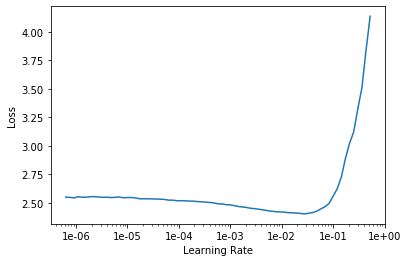

In [45]:
learn.recorder.plot()

### then train for several epochs with appropriate lr 

In [46]:
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,f_beta,time
0,2.227864,2.014264,0.156436,06:27
1,2.230419,1.999314,0.215314,06:09
2,2.233145,2.017429,0.151951,05:36
3,2.200499,1.997623,0.177419,05:45
4,2.110476,1.965809,0.164362,05:43
5,2.044198,1.883887,0.216444,06:31
6,1.986051,1.826045,0.232771,06:39
7,1.971081,1.815877,0.249696,06:15


This part is a bit hit and miss, under some combination of large enough bs, image_size and model it could look something like this. It could also look a bit worse. In any case, model should be improving but on its own still quite bad. Anyway, onwards and upwards.

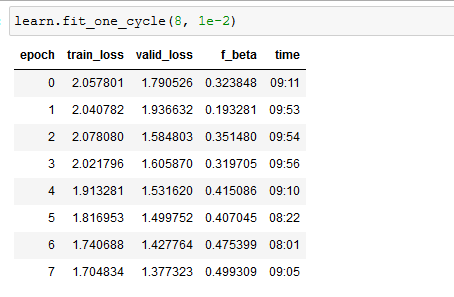

In [47]:
learn.save('herbarium-stage-1-toy-resnet50-128')

### then we unfreeze and fine-tune the arch

(Might have to restart the kernel for this, GPU disallowing)

In [42]:
learn.load('herbarium-stage-1-toy-resnet50-128')

Learner(data=ImageDataBunch;

Train: LabelList (8613 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
163,163,163,163,163
Path: D:\Data\Kaggle_HerbariumChallenge2020\nybg2020\train;

Valid: LabelList (2153 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
4232,23718,5340,31010,4232
Path: D:\Data\Kaggle_HerbariumChallenge2020\nybg2020\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

In [43]:
learn.unfreeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


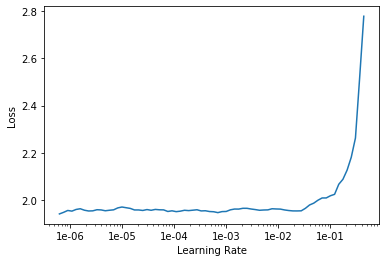

In [45]:
learn.recorder.plot()

Just looking to squeeze it a bit

In [46]:
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,f_beta,time
0,1.855871,1.807987,0.307015,06:41
1,1.602528,1.405006,0.463930,06:55
2,1.247569,1.282534,0.495171,06:13
3,1.008041,1.532819,0.488291,06:10
4,0.841835,1.347353,0.510646,06:09
5,0.732880,1.669577,0.476176,06:09
6,0.632370,0.448170,0.832342,06:10
7,0.553555,0.413855,0.849296,06:08


Performance should improve quite a lot here, reaching high 80+ % in terms of the performance metric.

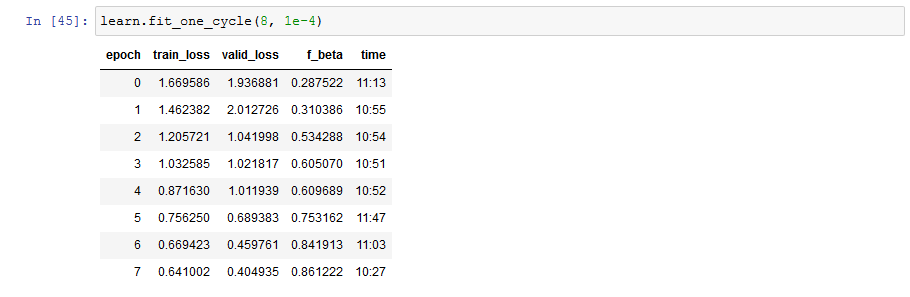

For more complex models and larger subsets, we can expect results to be something along this line. The model performance basically becomes very good (relatively speaking). The time however to train the epochs are long for larger subsets. 

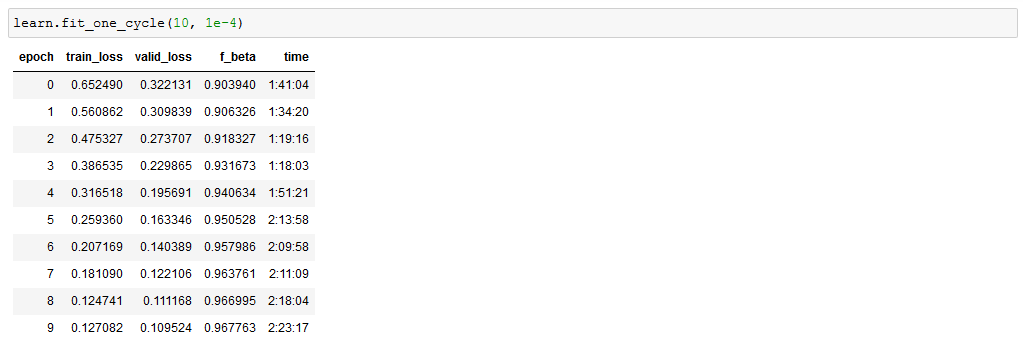

In [49]:
learn.save('herbarium-stage-2-toy-resnet50-128')

#### then we retrain the model on a higher resolution if GPUs allow it 

(Note that we'd have changed batchsize and image_size for this part)

In [42]:
learn.load('herbarium-stage-2-toy-resnet50-128')

Learner(data=ImageDataBunch;

Train: LabelList (8613 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
163,163,163,163,163
Path: D:\Data\Kaggle_HerbariumChallenge2020\nybg2020\train;

Valid: LabelList (2153 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
5340,163,23718,12779,17078
Path: D:\Data\Kaggle_HerbariumChallenge2020\nybg2020\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

In [43]:
learn.unfreeze()

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


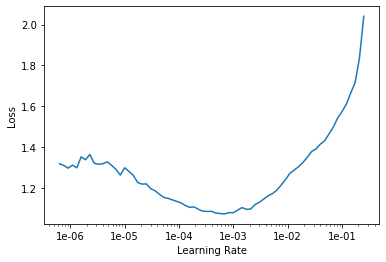

In [45]:
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(8, 3e-4)

epoch,train_loss,valid_loss,f_beta,time
0,0.671137,2.926330,0.323075,13:09
1,0.685522,1.414842,0.549464,12:12
2,0.569580,0.870619,0.638044,11:36
3,0.483527,0.465715,0.828604,11:40
4,0.400304,0.714427,0.734261,11:35
5,0.340582,0.234139,0.925508,11:48
6,0.250255,0.152443,0.956016,12:09
7,0.228029,0.147629,0.959684,12:00


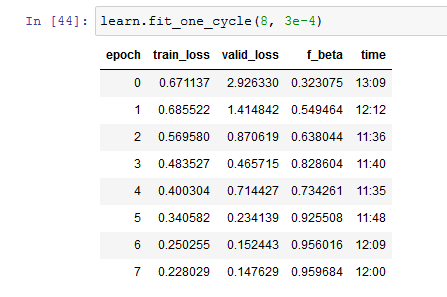

By this point, expect performance to get to high 90+% in terms of performance metric, even with 100-200 classes given a large enough batchsize

In [45]:
learn.save('herbarium-stage-2-toy-resnet50-256')

### finally we save the weights to load in other notebooks

In [40]:
learn.load('herbarium-stage-2-toy-resnet50-256')

Learner(data=ImageDataBunch;

Train: LabelList (8613 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
163,163,163,163,163
Path: D:\Data\Kaggle_HerbariumChallenge2020\nybg2020\train;

Valid: LabelList (2153 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
12779,23718,17078,11931,11931
Path: D:\Data\Kaggle_HerbariumChallenge2020\nybg2020\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchN

The deal is to create a replicate fastai model architecture, save model.state_dict() of the fastai model (not using learner.save()) and load state_dict from there for the pytorch model.

In [41]:
os.mkdir('models')

In [43]:
model_dir = 'models/'

In [44]:
torch.save({'state_dict': learn.model.state_dict()}
          , model_dir + 'herbarium-toy-resnet50-10-weights.pth'
          )

In [ ]:

#model_file = 'herbarium-toy-resnet50-10-weights.pth'
#weights = torch.load(model_dir + model_file)
#model.load_state_dict(weights['state_dict'])